# Задача

Запустите A/A-тест
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста.

In [1]:
import numpy as np
import pandas as pd
import locale
from locale import atof
from scipy import stats
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm, mannwhitneyu, ttest_ind, chisquare
import seaborn as sns
%matplotlib inline


from tqdm.auto import tqdm

In [4]:
df = pd.read_csv('./datasets/KarpovCourses/Statistics/BootStrap/hw_aa.csv', sep=';')

df.drop(['Unnamed: 0'], axis=1, inplace=True)

df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [79]:
# Проверяю наличие пропущенных значений:

df.isna().sum()

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [80]:
# Проверяю наличие дубликатов:

df.duplicated().sum()

0

In [81]:
# Проверяю тип данных в колонках:

df.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [ ]:
#### Проверяю уникальные значения в колонках:

In [82]:
df.experimentVariant.unique()

array([1, 0], dtype=int64)

In [83]:
df.experimentVariant.unique()

array([1, 0], dtype=int64)

In [86]:
df.purchase.unique()

array([0, 1], dtype=int64)

In [ ]:
# Проверяю равномерность распределения данных в АА-группах:

In [13]:
df.query('experimentVariant == 0') \
  .groupby('version') \
  .purchase.value_counts()

version   purchase
v2.8.0    0           41242
          1              41
v2.9.0    0           11031
          1             890
v3.7.4.0  0            3952
          1             252
v3.8.0.0  0            5366
          1             328
Name: purchase, dtype: int64

In [14]:
df.query('experimentVariant == 1') \
  .groupby('version') \
  .purchase.value_counts()

version   purchase
v2.8.0    0           39657
          1            1895
v2.9.0    0           11175
          1             858
v3.7.4.0  0            3955
          1             266
v3.8.0.0  0            5726
          1             384
Name: purchase, dtype: int64

In [ ]:
# Вывод: распределение данных в АА-группах более-менее одинаковое и не мешает проведению АА-теста.

In [ ]:
#### Запускаю A/A-тест, считаю FPR на уровне альфа = 0.05 (ставлю подвыборки без возвращения объемом 1000). 

In [7]:
n = 100000
simulations = 1000
n_s = 1000
res = []

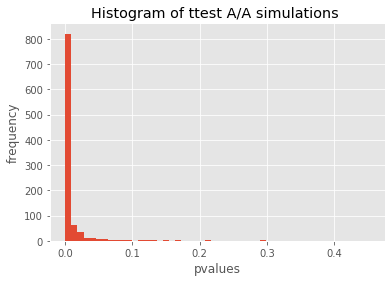

0.949

In [36]:
# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 0').sample(n_s, replace = False).purchase
    s2 = df.query('experimentVariant == 1').sample(n_s, replace = False).purchase
    
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [ ]:
# Вывод - похоже что сплит-система работает неправильно. Буду искать аномалию в данных.

In [ ]:
# Проверю как распределена конверсия между версиями в общем датафрейме:

In [14]:
# Считаю конверсию:

df_conversion = df.query('purchase == 1') \
                  .groupby('version', as_index=False) \
                  .agg({'purchase': 'count'}) \
                  .rename(columns={'purchase': 'true_purchases'})

df_conversion

,version,true_purchases
0,v2.8.0,1936
1,v2.9.0,1748
2,v3.7.4.0,518
3,v3.8.0.0,712


In [15]:
df_conversion['total_purchases'] = df.groupby('version', as_index=False) \
                                     .agg({'purchase': 'count'}) \
                                     .rename(columns={'purchase': 'total_purchases'}) \
                                     .total_purchases

df_conversion

,version,true_purchases,total_purchases
0,v2.8.0,1936,82835
1,v2.9.0,1748,23954
2,v3.7.4.0,518,8425
3,v3.8.0.0,712,11804


In [16]:
df_conversion['CR'] = df_conversion.true_purchases / df_conversion.total_purchases

df_conversion

,version,true_purchases,total_purchases,CR
0,v2.8.0,1936,82835,0.023372
1,v2.9.0,1748,23954,0.072973
2,v3.7.4.0,518,8425,0.061484
3,v3.8.0.0,712,11804,0.060319


In [ ]:
# В общем датафрейме в разбивке по версиям явных аномалий не вижу.

In [ ]:
# Посчитаю конверсию по версиям приложения для первой и второй А-групп:

In [7]:
#  Разобью за 1 и 2 группы и посмотрю в них CR:

exp_1 = df.query('experimentVariant == 0')

exp_2 = df.query('experimentVariant == 1')

In [8]:
# Считаю конверсию как отношение purchase == 1 ко всем purchase в 1 группе:

df_conversion_1 = exp_1.query('purchase == 1') \
                     .groupby('version', as_index=False) \
                     .agg({'purchase': 'count'}) \
                     .rename(columns={'purchase': 'true_purchases'})


df_conversion_1['total_purchases'] = exp_1.groupby('version', as_index=False) \
                                        .agg({'purchase': 'count'}) \
                                        .rename(columns={'purchase': 'total_purchases'}).total_purchases


df_conversion_1['CR'] = df_conversion_1.true_purchases / df_conversion_1.total_purchases

df_conversion_1

,version,true_purchases,total_purchases,CR
0,v2.8.0,41,41283,0.000993
1,v2.9.0,890,11921,0.074658
2,v3.7.4.0,252,4204,0.059943
3,v3.8.0.0,328,5694,0.057604


In [9]:
# Считаю конверсию как отношение purchase == 1 ко всем purchase во 2 группе:

df_conversion_2 = exp_2.query('purchase == 1') \
                     .groupby('version', as_index=False) \
                     .agg({'purchase': 'count'}) \
                     .rename(columns={'purchase': 'true_purchases'})


df_conversion_2['total_purchases'] = exp_2.groupby('version', as_index=False) \
                                        .agg({'purchase': 'count'}) \
                                        .rename(columns={'purchase': 'total_purchases'}) \
                                        .total_purchases


df_conversion_2['CR'] = df_conversion_2.true_purchases / df_conversion_2.total_purchases

df_conversion_2

,version,true_purchases,total_purchases,CR
0,v2.8.0,1895,41552,0.045606
1,v2.9.0,858,12033,0.071304
2,v3.7.4.0,266,4221,0.063018
3,v3.8.0.0,384,6110,0.062848


In [10]:
df_conversion_1

,version,true_purchases,total_purchases,CR
0,v2.8.0,41,41283,0.000993
1,v2.9.0,890,11921,0.074658
2,v3.7.4.0,252,4204,0.059943
3,v3.8.0.0,328,5694,0.057604


In [ ]:
# Вывод: в первой группе у версии v2.8.0 наблюдается экстремально низкий CR.

In [ ]:
# Запускаю bootstrap для того чтобы проверить попарно по версиям MP p-value:

In [39]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

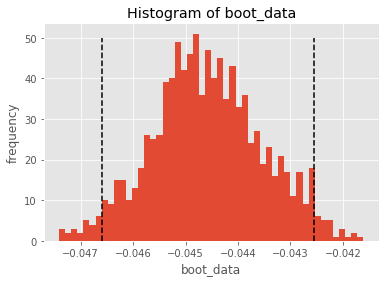

{'boot_data': [-0.044642857142857144,
  -0.04254909510974201,
  -0.04615902964959569,
  -0.044907585675779745,
  -0.046688486715440895,
  -0.045581440123219095,
  -0.0439449364651521,
  -0.04233249903735079,
  -0.04497978436657682,
  -0.04591836734693878,
  -0.04418559876780901,
  -0.043704274162495185,
  -0.04574990373507894,
  -0.04510011551790528,
  -0.042765691182133234,
  -0.044666923373122835,
  -0.043583943011166734,
  -0.0442096649980747,
  -0.042910088563727376,
  -0.04406526761648055,
  -0.04457065845206007,
  -0.044931651906045436,
  -0.0431266846361186,
  -0.04673661917597228,
  -0.0447631882941856,
  -0.044931651906045436,
  -0.0439449364651521,
  -0.0439449364651521,
  -0.04355987678090104,
  -0.045990566037735846,
  -0.04495571813631113,
  -0.04432999614940316,
  -0.04488351944551405,
  -0.04413746630727763,
  -0.04353581055063535,
  -0.04510011551790528,
  -0.04625529457065845,
  -0.04286195610319599,
  -0.044257797458606085,
  -0.0447631882941856,
  -0.0450038505968425

In [40]:
# Сравниваю версии v2.8.0 в обоих вариантах выборки

get_bootstrap(exp_1.query('version == "v2.8.0"').purchase, exp_2.query('version == "v2.8.0"').purchase)

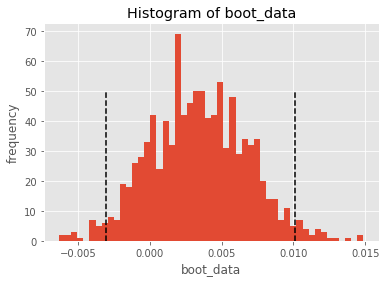

{'boot_data': [-0.00033241918058671987,
  0.0034904013961605585,
  0.002742458239840439,
  0.0032410870107205184,
  -0.0004986287708800798,
  8.310479514667997e-05,
  0.012133300091415274,
  0.0016620959029335994,
  0.0015789911077869192,
  0.0049031829136541175,
  -0.0004986287708800798,
  0.0033241918058671987,
  0.005651126069974238,
  0.0017452006980802793,
  0.0034904013961605585,
  0.005817335660267597,
  0.0015789911077869192,
  0.002077619878666999,
  0.007313221972907837,
  0.0036566109864539184,
  0.005401811684534198,
  0.007147012382614477,
  0.0036566109864539184,
  0.006731488406881077,
  0.007147012382614477,
  0.007313221972907837,
  0.002742458239840439,
  0.008310479514667997,
  0.0013296767223468795,
  -8.310479514667997e-05,
  0.0039890301670406384,
  0.0034072966010138786,
  0.0019945150835203192,
  -0.0018283054932269592,
  0.005318706889387518,
  0.002243829468960359,
  0.009473946646721515,
  0.00041552397573339984,
  -0.0033241918058671987,
  0.0001662095902933

In [41]:
# Сравниваю версии v2.9.0 в обоих вариантах выборки

get_bootstrap(exp_1.query('version == "v2.9.0"').purchase, exp_2.query('version == "v2.9.0"').purchase)

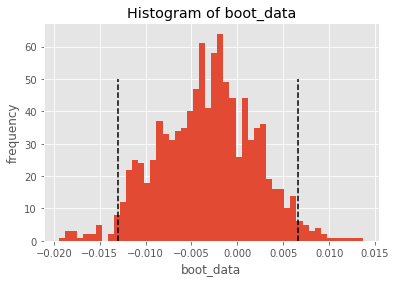

{'boot_data': [0.0018952854773750297,
  -0.001658374792703151,
  -0.009713338071547027,
  -0.011608623548922056,
  -0.006396588486140725,
  -0.0111348021795783,
  -0.004975124378109453,
  -0.006396588486140725,
  -0.002369106846718787,
  -0.003316749585406302,
  -0.005212035062781332,
  0.006633499170812604,
  -0.007107320540156361,
  -0.006396588486140725,
  -0.006633499170812604,
  0.0011845534233593934,
  -0.009002606017531391,
  -0.0014214641080312722,
  -0.002606017531390666,
  0.0014214641080312722,
  0.0018952854773750297,
  -0.006396588486140725,
  -0.0007107320540156361,
  -0.002606017531390666,
  -0.006159677801468846,
  0.0028429282160625444,
  -0.015162283819000238,
  0.0042643923240938165,
  -0.00734423122482824,
  -0.002606017531390666,
  0.006159677801468846,
  0.0014214641080312722,
  0.0021321961620469083,
  -0.0037905709547500594,
  0.0018952854773750297,
  -0.009002606017531391,
  0.0011845534233593934,
  -0.00023691068467187872,
  -0.00023691068467187872,
  -0.00426

In [42]:
# Сравниваю версии v3.7.4.0 в обоих вариантах выборки

get_bootstrap(exp_1.query('version == "v3.7.4.0"').purchase, exp_2.query('version == "v3.7.4.0"').purchase)

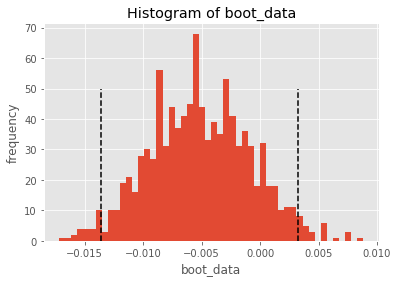

{'boot_data': [-0.007364975450081833,
  0.002127659574468085,
  0.0003273322422258593,
  -0.005400981996726678,
  -0.010310965630114566,
  -0.007855973813420621,
  -0.010310965630114566,
  -0.006546644844517185,
  0.0004909983633387888,
  -0.004582651391162029,
  -0.003600654664484452,
  -0.0027823240589198036,
  0.001309328968903437,
  -0.006710310965630115,
  -0.010310965630114566,
  -0.0008183306055646482,
  -0.002618657937806874,
  -0.0011456628477905073,
  0.00016366612111292964,
  -0.009819967266775777,
  0.0004909983633387888,
  -0.006382978723404255,
  -0.0057283142389525366,
  -0.009983633387888708,
  -0.00851063829787234,
  -0.009165302782324058,
  -0.006219312602291326,
  -0.015220949263502455,
  0.0008183306055646482,
  -0.0057283142389525366,
  -0.00834697217675941,
  -0.0014729950900163667,
  -0.005237315875613748,
  -0.010638297872340425,
  -0.0011456628477905073,
  0.0044189852700491,
  -0.001309328968903437,
  -0.003600654664484452,
  -0.00425531914893617,
  -0.0078559

In [43]:
# Сравниваю версии v3.8.0.0 в обоих вариантах выборки

get_bootstrap(exp_1.query('version == "v3.8.0.0"').purchase, exp_2.query('version == "v3.8.0.0"').purchase)

In [ ]:
# Вывод: в 1 случае получаю низкий p-value < 0.05. Наряду с экстремально низким CR в этой паре прихжу к вывду что наличие этой 
пары привносит ошибку в АА-тест. Удаляю данные с версией v2.8.0 из эксперимента.

In [6]:
# Удаляю ошибочные данные:

df_fixed = df.query('version != "v2.8.0"')

In [53]:
# Запускаю АА-тест без аномалии в данных:

n = 100000
simulations = 1000
n_s = 1000
res = []

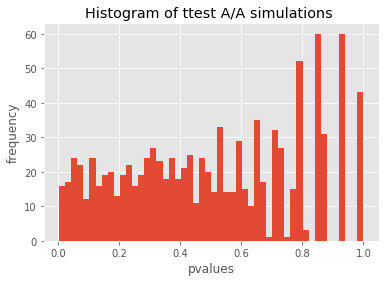

0.042

In [54]:
# Запуск симуляций A/A теста на очищенных данных:

for i in tqdm(range(simulations)):
    s1 = df_fixed.query('experimentVariant == 0').sample(n_s, replace = False).purchase
    s2 = df_fixed.query('experimentVariant == 1').sample(n_s, replace = False).purchase
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [ ]:
Вывод:

полученный график распределения содержит отдельные "зубья" в правой части.
Это может быть вызвано величиной изначальной выборки (мала), либо же особенностью статистического критерия.    
полученное в АА-тесте на исправленных данных значение p-value позволяет сделать вывод о том, что данные подходят для 
проведения дальнейших АВ-тестов.

Проблема заключалась в экстремально низкой конверсии для версии v2.8.0 в группе данных experimentVariant = 0.
при сопоставимом количестве скачиваний в группе данных experimentVariant = 1.

Вполне вероятно что данные для этих групп собирались в разное время. 
Возможно, первая версия приложения в проде работала с ошибкой, котрую затем пофиксили. 
Может быть, в момент выкатывания версии v2.8.0 пользователи из первой группы столкнулись с проблемами в работе приложения
из-за нестабильной работы сервера или отутствием возможности оперативно решить проблемы с приложением обратившись с в службу
поддержки.

Для дополнительного анализа было бы здорово посмотреть полные логи работы приложения со временем и сообщениями об ошибках.